
# Data Encoding in QML — Practice Notebook

**Goal.** Hands-on practice with *data encoding* for Quantum Machine Learning (QML), using only the code patterns shown in the lesson:
- Basis encoding
- Amplitude encoding
- Angle encoding
- Phase encoding
- Dense angle encoding
- Built-in feature maps: `efficient_su2`, `z_feature_map`, `zz_feature_map`, `pauli_feature_map`

Each section contains: a short explanation, a runnable example, and **Your turn** mini-exercises.


In [ ]:
!pip install -U "cryptography<44" --quiet
!pip install -U pyopenssl pydrive2 --quiet

!pip install --quiet \
  qiskit==2.2.3 \
  qiskit-aer==0.17.2 \
  qiskit-ibm-runtime==0.43.1 \
  ibm-cloud-sdk-core==3.24.2 \
  ibm-platform-services==0.71.0 \
  qiskit-machine-learning \
  rustworkx==0.17.1 \
  httpx==0.28.1 httpcore==1.0.9 \
  pylatexenc==2.10 \
  seaborn tqdm

## Notation

**Dataset.** Let $X=\{\mathbf{x}^{(j)}\}_{j=1}^M$ with each $\mathbf{x}^{(j)}\in\mathbb{R}^N$.  
We use $\Phi(\mathbf{x})$ for a generic ML feature map and $U(\mathbf{x})$ for its quantum-circuit unitary.

- We will usually load **one** vector $\mathbf{x}\in\mathbb{R}^N$ at a time.  
- In QML, **normalization** matters:  
  - Classical min–max normalization rescales each feature column.  
  - Quantum states must satisfy $\|\psi\|^2=\langle\psi|\psi\rangle=1$.  
    E.g., in **amplitude encoding** we rescale so that $\sum_i |x_i|^2=1$.  
  - In **angle/phase** encodings we typically rescale features to $(0,2\pi]$ to avoid modulo-$2\pi$ information loss.

We will also use a small example dataset:  

$$
X_{\rm ex}=\{(4,8,5),(9,8,6),(2,9,2),(5,7,0),(3,7,5)\},
$$

and frequently the single vector $\mathbf{x}^{(1)}=(4,8,5)$.


In [8]:
# Common imports used in the examples below (pulled from the lesson)
from math import pi
import math
import numpy as np

# Qiskit core utilities used in the lesson
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# Visualization helpers used in the lesson
from qiskit.visualization.bloch import Bloch
from qiskit.visualization.state_visualization import _bloch_multivector_data

# Built-in feature maps used in the lesson
from qiskit.circuit.library import efficient_su2, z_feature_map, zz_feature_map, pauli_feature_map

# Matplotlib for a few plots (also from the lesson gallery)
import matplotlib.pyplot as plt



### Helper: Bloch-sphere visualizer

The following function is the same helper used in the lesson. It plots a sequence of single-qubit states on a single Bloch sphere to visualize rotations.


In [2]:
def plot_Nstates(states, axis=None, plot_trace_points=True):
    """Plot N Statevector objects on one Bloch sphere (from the lesson)."""
    bloch_vecs = [_bloch_multivector_data(s)[0] for s in states]

    if axis is None:
        bloch_plot = Bloch()
    else:
        bloch_plot = Bloch(axes=axis)

    bloch_plot.add_vectors(bloch_vecs)

    if len(states) > 1:
        def rgba_map(x, num):
            g = (0.95 - 0.05) / (num - 1)
            i = 0.95 - g * num
            y = g * x + i
            return (0.0, y, 0.0, 0.7)

        num = len(states)
        bloch_plot.vector_color = [rgba_map(x, num) for x in range(1, num + 1)]

    bloch_plot.vector_width = 3
    bloch_plot.vector_style = "simple"

    if plot_trace_points:
        def trace_points(bloch_vec1, bloch_vec2):
            n_points = 15
            thetas = np.arccos([bloch_vec1[2], bloch_vec2[2]])
            phis = np.arctan2([bloch_vec1[1], bloch_vec2[1]], [bloch_vec1[0], bloch_vec2[0]])
            if phis[1] < 0:
                phis[1] = phis[1] + 2 * pi
            angles0 = np.linspace(phis[0], phis[1], n_points)
            angles1 = np.linspace(thetas[0], thetas[1], n_points)

            xp = np.cos(angles0) * np.sin(angles1)
            yp = np.sin(angles0) * np.sin(angles1)
            zp = np.cos(angles1)
            pnts = [xp, yp, zp]
            bloch_plot.add_points(pnts)
            bloch_plot.point_color = "k"
            bloch_plot.point_size = [4] * len(bloch_plot.points)
            bloch_plot.point_marker = ["o"]

        for i in range(len(bloch_vecs) - 1):
            trace_points(bloch_vecs[i], bloch_vecs[i + 1])

    bloch_plot.sphere_alpha = 0.05
    bloch_plot.frame_alpha = 0.15
    bloch_plot.figsize = [4, 4]
    bloch_plot.render()


## 1) Basis Encoding

**Idea.** Encode a classical $P$-bit string into a computational basis state of a $P$-qubit system.  
For $(b_1, \dots, b_P) \in \{0,1\}^P$, the quantum state is:

$$
|x\rangle = |b_1, b_2, \dots, b_P\rangle.
$$

Each classical bit maps directly to one qubit  
($0 \rightarrow |0\rangle$, $1 \rightarrow |1\rangle$),  
so the binary structure of data is preserved exactly.

---

**Example.** Encode $(5,7,0)$ with 4 bits per feature:  

$$
5 \to (0101), \quad
7 \to (0111), \quad
0 \to (0000),
$$

giving the 12-qubit state  

$$
|010101110000\rangle.
$$

Each feature uses a distinct group of qubits,  
so $(5,7,0)$ becomes a structured quantum basis state.


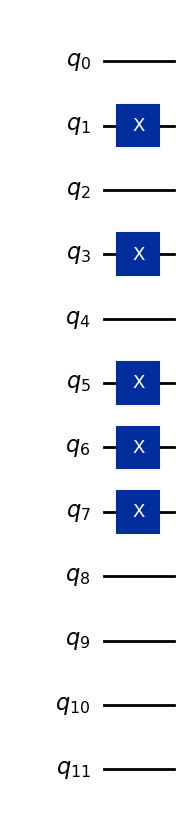

In [3]:
# Example code from the lesson, generalized to (5,7,0)
x = 5  # 0101
y = 7  # 0111
z = 0  # 0000

x_bits = [int(b) for b in format(x, "04b")]
y_bits = [int(b) for b in format(y, "04b")]
z_bits = [int(b) for b in format(z, "04b")]
all_bits = x_bits + y_bits + z_bits

qc_basis = QuantumCircuit(12)
for idx, bit in enumerate(all_bits):
    if bit == 1:
        qc_basis.x(idx)

qc_basis.draw("mpl")


**Your turn.** Encode $\mathbf{x}^{(1)}=(4,8,5)$ using 4 bits per feature.

- Write code to build the corresponding quantum circuit with $12$ qubits.  
- Hint: follow the exact pattern above (format to 4-bit binary, append, apply `x` on 1s).


## 2) Amplitude Encoding

**Idea.** Encode a normalized vector $\mathbf{x} = (x_1, \dots, x_N)$ into the amplitudes of a quantum state:

$$
|\psi_{\mathbf{x}}\rangle = \frac{1}{\alpha}\sum_{i=1}^{N} x_i |i\rangle, \qquad
\sum_{i=1}^{N} |x_i|^2 = |\alpha|^2.
$$

A system of $n$ qubits can represent $2^n$ complex amplitudes.  
Therefore, choose $n$ so that $2^n \ge N$.  
If $N$ is not a power of two, **pad with zeros** until the length is $2^n$.

---

**Example.**  
Let $\mathbf{x} = (4, 8, 5)$.  
Its normalized version is:

$$
\frac{1}{\sqrt{4^2 + 8^2 + 5^2}}(4, 8, 5, 0)
  = \left(\frac{4}{\sqrt{105}}, \frac{8}{\sqrt{105}}, \frac{5}{\sqrt{105}}, 0\right).
$$

Since $N=3 < 4 = 2^2$, we use 2 qubits to represent these 4 amplitudes.

Amplitude encoding stores all values **simultaneously** in one quantum state,  
but preparing such states can be **computationally expensive** for large $n$.


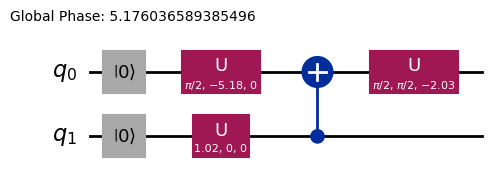

In [5]:
# Example from the lesson: encode (4,8,5) on 2 qubits (pad with a zero)
desired_state = [
    4 / math.sqrt(105),
    8 / math.sqrt(105),
    5 / math.sqrt(105),
    0 / math.sqrt(105),
]

qc_amp = QuantumCircuit(2)
qc_amp.initialize(desired_state, [0, 1])
qc_amp.decompose(reps=5).draw(output="mpl")


**Your turn A.** Normalize and write the state $|\psi_{\mathbf{x}}\rangle$ for $\mathbf{x}=(9,8,6,2,9,2)$.  
*(Just compute the normalization constant and list the amplitudes; you can print them.)*

**Your turn B.** Build a circuit using `initialize` that loads the normalized amplitudes for $\mathbf{x}=(9,8,6,2,9,2)$.  
- Choose $n$ with $2^n \ge 6$ and **pad with zeros** to length $2^n$.


## 3) Angle Encoding (Y-axis)

**Idea.** Map each feature value to a rotation angle of $R_Y(\theta)$ on one qubit:

$$
|x_k\rangle = R_Y(\theta = x_k)|0\rangle
= \cos\!\left(\tfrac{x_k}{2}\right)|0\rangle + \sin\!\left(\tfrac{x_k}{2}\right)|1\rangle.
$$

Each feature is stored as a **rotation around the Y-axis**, producing a product state across qubits.  
Because rotation angles are periodic, features should be **rescaled to $(0, 2\pi]$** to preserve relative variation.

---

**Example.**  
If $x = \tfrac{\pi}{2}$, then:

$$
R_Y\!\left(\tfrac{\pi}{2}\right)|0\rangle
= \tfrac{1}{\sqrt{2}}(|0\rangle + |1\rangle),
$$

which places the qubit on the equator of the Bloch sphere.

Angle encoding is easy to implement and hardware-efficient,  
making it a common choice in quantum machine learning circuits.


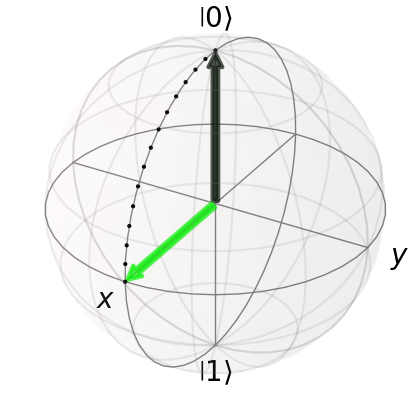

In [8]:
qc = QuantumCircuit(1)
state_before = Statevector.from_instruction(qc)
qc.ry(pi/2, 0)          # encode theta = pi/2
state_after = Statevector.from_instruction(qc)
plot_Nstates((state_before, state_after), axis=None, plot_trace_points=True)


**Your turn.** Encode $\mathbf{x}=(0,\pi/4,\pi/2)$ using angle encoding on three qubits (depth $\approx 1$ before transpilation).  
- Build a circuit with `ry(2*x_k)` or `ry(x_k)` consistently with the formula above.


## 4) Phase Encoding (Z-axis)

**Idea.** Initialize each qubit in the superposition state $|+\rangle = H|0\rangle$,  
then apply a phase rotation $P(\phi) = e^{i\phi/2} R_Z(\phi)$:

$$
|x_k\rangle = P(\phi = x_k)|+\rangle
= \tfrac{1}{\sqrt{2}}\big(|0\rangle + e^{i x_k}|1\rangle\big).
$$

Each feature controls the **relative phase** between $|0\rangle$ and $|1\rangle$,  
while the amplitude remains unchanged.  
Thus, the encoded information appears as interference effects during later operations.

As with angle encoding, the state is separable across qubits (a **product state**),  
so features should be **rescaled to $(0, 2\pi]$** to preserve their distinctiveness.


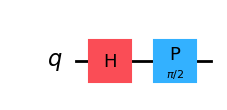

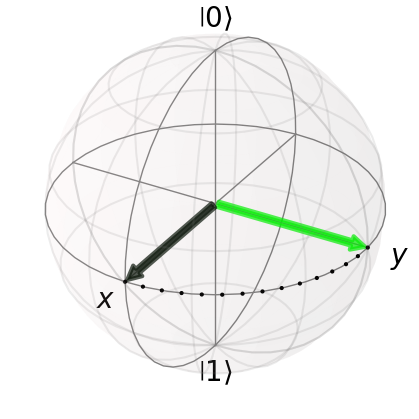

In [10]:
qc = QuantumCircuit(1)
qc.h(0)
state1 = Statevector.from_instruction(qc)
qc.p(pi/2, 0)  # encode phi = pi/2
state2 = Statevector.from_instruction(qc)
plot_Nstates((state1, state2), axis=None, plot_trace_points=True)
qc.draw("mpl", scale=1)


**Your turn A.** How many qubits are needed to phase-encode 8 features? *(Answer in a markdown cell below.)*

**Your turn B.** Phase-encode $\mathbf{x}=(4,8,5,9,8,6,2,9,2,5,7,0)$  
(treat numbers as raw angles; in practice rescale to $(0, 2\pi]$).


## 5) Dense Angle Encoding (DAE)

**Idea.** Encode **two** features onto **one** qubit:  
apply first a rotation around the Y-axis, then a rotation around the Z-axis:

$$
|x_{2k-1}, x_{2k}\rangle
= R_Z(\phi = x_{2k})\,R_Y(\theta = x_{2k-1})\,|0\rangle
= \cos\!\left(\tfrac{\theta}{2}\right)|0\rangle
+ e^{i\phi}\sin\!\left(\tfrac{\theta}{2}\right)|1\rangle.
$$

This method combines both **magnitude** (through $R_Y$) and **phase** (through $R_Z$) information  
on the same qubit, allowing more compact feature representation.

Hence, encoding $N$ features requires only $\lceil N/2 \rceil$ qubits.  
DAE is useful when qubit resources are limited while moderate feature density is desired.


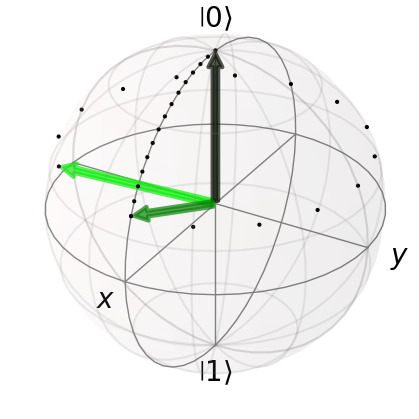

In [12]:
# Demo: theta=3*pi/8, phi=7*pi/4 on one qubit, visualized
qc = QuantumCircuit(1)
s0 = Statevector.from_instruction(qc)
qc.ry(3*pi/8, 0)
s1 = Statevector.from_instruction(qc)
qc.rz(7*pi/4, 0)
s2 = Statevector.from_instruction(qc)
plot_Nstates((s0, s1, s2), axis=None, plot_trace_points=True)


**Your turn.** DAE-encode $\mathbf{x}=(4,8,5,9,8,6,2,9,2,5,7,0,3,7,5)$.  
- Use one qubit per pair $(x_{2k-1}, x_{2k})$: apply `ry(x_{2k-1})` then `rz(x_{2k})`.


## 6) EfficientSU2 Encoding

**Idea.**  
The `EfficientSU2` circuit encodes a classical vector $\mathbf{x}$ into a quantum state through layers of parameterized rotations (`RY`, `RZ`, `RY`) followed by entangling operations such as `CX`.  
It is a compact and expressive encoding method that maps data into the high-dimensional Hilbert space of qubits, allowing both individual feature representation and correlation through entanglement.  
The order of features in $\mathbf{x}$ determines which gate each value is assigned to — Qiskit fills parameters from qubit 0 upward through each layer.  
While this order is arbitrary, it must remain consistent throughout encoding and training.  
Increasing the number of qubits or repetitions (`reps`) allows more parameters to be encoded, but also increases circuit depth, so a balance between expressivity and efficiency is needed.


---

**Structure.**  
Each layer of the circuit consists of three rotation gates per qubit — `RY`, `RZ`, and `RY` — followed by an entangling layer (typically made of `CX` gates).  
For $r$ repetitions, the overall circuit is expressed as:

$$
U_{\text{EffSU2}}(\mathbf{x}) =
\prod_{s=1}^{r} 
\left[
U_{\text{ent}} 
\prod_{i=1}^{n}
R_Y(\theta_{i,3}) R_Z(\theta_{i,2}) R_Y(\theta_{i,1})
\right],
$$

where:
- $U_{\text{ent}}$ is the entangling layer connecting qubits,
- and $\theta_{i,k}$ are trainable or data-dependent parameters.

This structure allows both **local feature encoding** (via rotation gates)  
and **global feature correlation** (via entanglement).

---

**Example 1.**  
A simple 2-qubit `EfficientSU2` circuit with one repetition (`reps=1`).


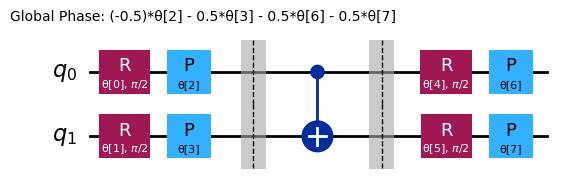

In [5]:
from qiskit.circuit.library import efficient_su2

circ_su2 = efficient_su2(num_qubits=2, reps=1, insert_barriers=True)
circ_su2.decompose().draw("mpl")


**Example 2.** 
Now we assign real data values to the parameters.
Given the feature vector $\mathbf{x} = [0.1, 0.2, 0.3, \dots, 1.2]$,
we construct a 3-qubit circuit with the same structure and assign parameters accordingly.

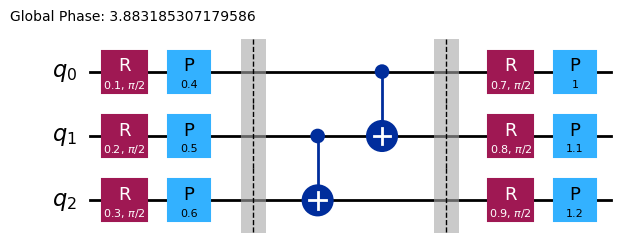

In [6]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
circuit = efficient_su2(num_qubits=3, reps=1, insert_barriers=True)
encode = circuit.assign_parameters(x)
encode.decompose().draw(output="mpl")

**Your turn.** Encode  
$\mathbf{x} = (0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3)$  
using an `EfficientSU2` circuit with 3 qubits, `reps=1`, and `insert_barriers=True`.  
Assign parameters to $\mathbf{x}$ and draw the decomposed circuit.

---

## b) Z Feature Map (ZFM)

**Idea.**  
The **Z Feature Map (ZFM)** extends simple phase encoding by alternating layers of **Hadamard** and **phase (P)** gates.  
Each feature $x_i$ in the data vector $\mathbf{x}$ is mapped directly to a qubit through a phase rotation.  
This structure transforms classical data into a quantum feature space while keeping the quantum state separable,  
making it computationally efficient for simulation and analysis.

The ZFM circuit alternates between applying a Hadamard layer and a phase layer:  
- The **Hadamard layer** applies $H^{\otimes N}$ to all qubits, creating superposition.  
- The **phase layer** applies $P(x_i)$ on each qubit *i*, introducing data-dependent phase shifts.  
- Repeating this structure $r$ times yields the full unitary:

$$
U_{\text{ZFM}}^{(r)}(\mathbf{x}) = 
\prod_{s=1}^{r} 
\left[
\bigotimes_{k=1}^{N} P(x_k) \; H^{\otimes N}
\right]
$$

Each repetition increases the circuit’s expressivity by applying multiple layers of phase encoding.  
For $N$ features, use $N$ qubits — one feature per qubit.

---

**Example 1. Manual Construction (2 qubits, r = 1)**  
Encoding $\mathbf{x} = \left(\tfrac{\pi}{2}, \tfrac{\pi}{3}\right)$ onto two qubits using explicit Hadamard and phase gates.


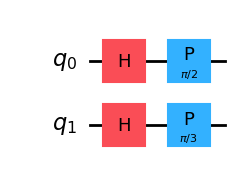

In [9]:
qc0 = QuantumCircuit(1)
qc1 = QuantumCircuit(1)
 
qc0.h(0)
qc0.p(pi / 2, 0)
 
qc1.h(0)
qc1.p(pi / 3, 0)
 
# Combine circuits qc0 and qc1 into 1 circuit
qc = QuantumCircuit(2)
qc.compose(qc0, [0], inplace=True)
qc.compose(qc1, [1], inplace=True)
 
qc.draw("mpl", scale=1)



**Example 2. Using Qiskit’s Built-in Class (r = 3)**
The same data vector is now encoded with three repetitions using z_feature_map.




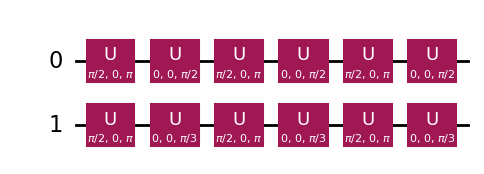

In [10]:
from qiskit.circuit.library import z_feature_map

zfeature_map = z_feature_map(feature_dimension=2, reps=3)
zfeature_map = zfeature_map.assign_parameters([(1 / 2) * pi / 2, (1 / 2) * pi / 3])
zfeature_map.decompose().draw("mpl")

**Your turn.** Encode  $\mathbf{x} = \left(\tfrac{\pi}{4}, \tfrac{\pi}{5}, \tfrac{\pi}{6}\right)$ using a `z_feature_map` circuit with 3 qubits and `reps=2`.  
Assign parameters properly and draw the decomposed circuit.

### c) ZZ Feature Map (ZZFM)

**Idea.**  
The **ZZ Feature Map (ZZFM)** extends the **Z Feature Map** by introducing **two-qubit entangling gates** through the  
$R_{ZZ}(\theta)$ operation, which enables **nonlinear feature interactions**.  
Each entangling operation introduces correlations between pairs of qubits, allowing the circuit to represent joint relationships between features.

The entangling gate is defined as:
$$
R_{ZZ}(\theta) = e^{-i\frac{\theta}{2} Z \otimes Z},
$$
which becomes maximally entangling when $\theta = \tfrac{\pi}{2}$.  
The argument $\theta_{q,p}$ for each pair of qubits $(q,p)$ is determined by:
$$
\theta_{q,p} = \phi(x_q, x_p) = 2(\pi - x_q)(\pi - x_p).
$$

---

**Circuit Structure.**  
The complete ZZFM circuit consists of:
1. **Hadamard layer**: creates superpositions ($H^{\otimes N}$).  
2. **Phase layer**: encodes data via $P(x_i)$ rotations.  
3. **Entangling layer**: applies $R_{ZZ}(\theta_{q,p})$ between selected qubit pairs.  

A single repetition can be written as:
$$
U_{\text{ZZFM}}(\mathbf{x}) =
U_{ZZ}(\mathbf{x})
\left(
\bigotimes_{k=1}^{N} P(x_k)
\right)
H^{\otimes N},
$$
and with $r$ repetitions:
$$
U_{\text{ZZFM}}^{(r)}(\mathbf{x}) =
\prod_{s=1}^{r}
\left[
U_{ZZ}(\mathbf{x})
\left(
\bigotimes_{k=1}^{N} P(x_k)
\right)
H^{\otimes N}
\right].
$$

---

**Example 1.**  
Single entangling gate $R_{ZZ}(\pi)$ between two qubits.


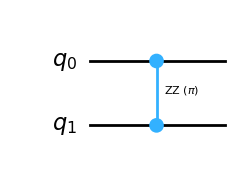

In [11]:
qc = QuantumCircuit(2)
qc.rzz(pi, 0, 1)
qc.draw("mpl", scale=1)


We can decompose it to reveal the underlying gate operations:



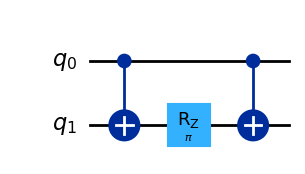

In [12]:
qc.decompose().draw("mpl", scale=1)


This gate entangles two qubits, with the degree of entanglement determined by the encoded feature value.

---

**Example 2. Two-Qubit ZZFM (Linear Entanglement, r = 1)**

Each feature is mapped to one qubit, and the ZZ gate connects them according to the mapping
$\theta_{1,2} = 2(\pi - x_1)(\pi - x_2)$.


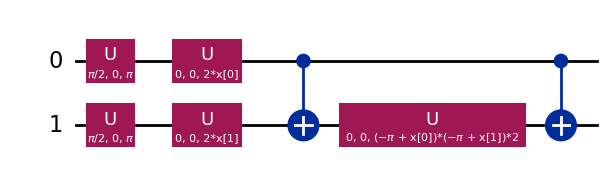

In [13]:
from qiskit.circuit.library import zz_feature_map

feature_dim = 2
zzfeature_map = zz_feature_map(
feature_dimension=feature_dim, entanglement="linear", reps=1
)
zzfeature_map.decompose(reps=1).draw("mpl", scale=1)


Qiskit internally combines features $(x_1, x_2)$ through  
$\theta_{1,2} = 2(\pi - x_1)(\pi - x_2)$  
before passing them to the entangling gates.

---

**Example 3: Four-Qubit ZZFM with Linear Entanglement**

Here we expand to 4 qubits and see multiple entangling pairs in action.



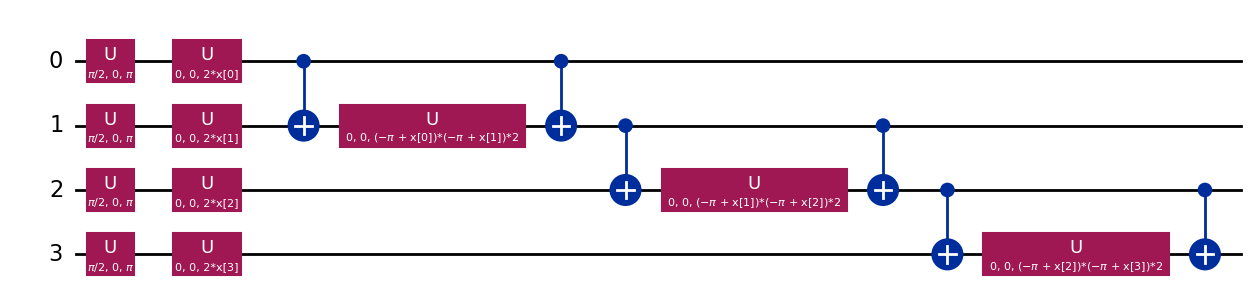

In [14]:
feature_dim = 4
zzfeature_map = zz_feature_map(
feature_dimension=feature_dim, entanglement="linear", reps=1
)
zzfeature_map.decompose().draw("mpl", scale=1)

**Your turn.** Create a `zz_feature_map` circuit for $\mathbf{x} = (0.5\pi, 0.3\pi, 0.7\pi)$ using **3 qubits**, `reps=2`, and **circular entanglement**.  
Decompose the circuit and visualize it.

### d) Pauli Feature Map (PFM)

**Idea.**  
The **Pauli Feature Map (PFM)** is a generalization of the **Z** and **ZZ Feature Maps**, allowing data encoding through **arbitrary Pauli operators**.  
It provides a unified framework for representing both single-qubit rotations and multi-qubit entangling interactions using combinations of $X$, $Y$, and $Z$ gates.  
This flexibility enables modeling of complex, **Ising-like couplings** between qubits, where correlations between features are mapped directly into quantum interactions.

The general unitary for PFM is:
$$
U(\mathbf{x}) = \exp\left(
i \sum_{S \in I} \phi_S(\mathbf{x})
\prod_{i \in S} \sigma_i
\right),
$$
where $\sigma_i \in \{I, X, Y, Z\}$ and $S$ enumerates the sets of qubits acted on together.  
For multiple repetitions:
$$
U_{\text{PFM}}(\mathbf{x}) =
\prod_{s=1}^{r} U(\mathbf{x}) H^{\otimes n}.
$$

---

**Mapping Function.**  
The mapping $\phi_S(\mathbf{x})$ determines how data features control the rotations:

- For single-qubit gates: $\phi_S(\mathbf{x}) = x_i$  
- For multi-qubit gates: $\phi_S(\mathbf{x}) = \prod_{j \in S} (\pi - x_j)$

This structure allows both **local** (single-qubit) and **global** (entangling) feature dependencies to be captured in one circuit.

---

**Example 1. Three-Qubit Pauli Feature Map**  

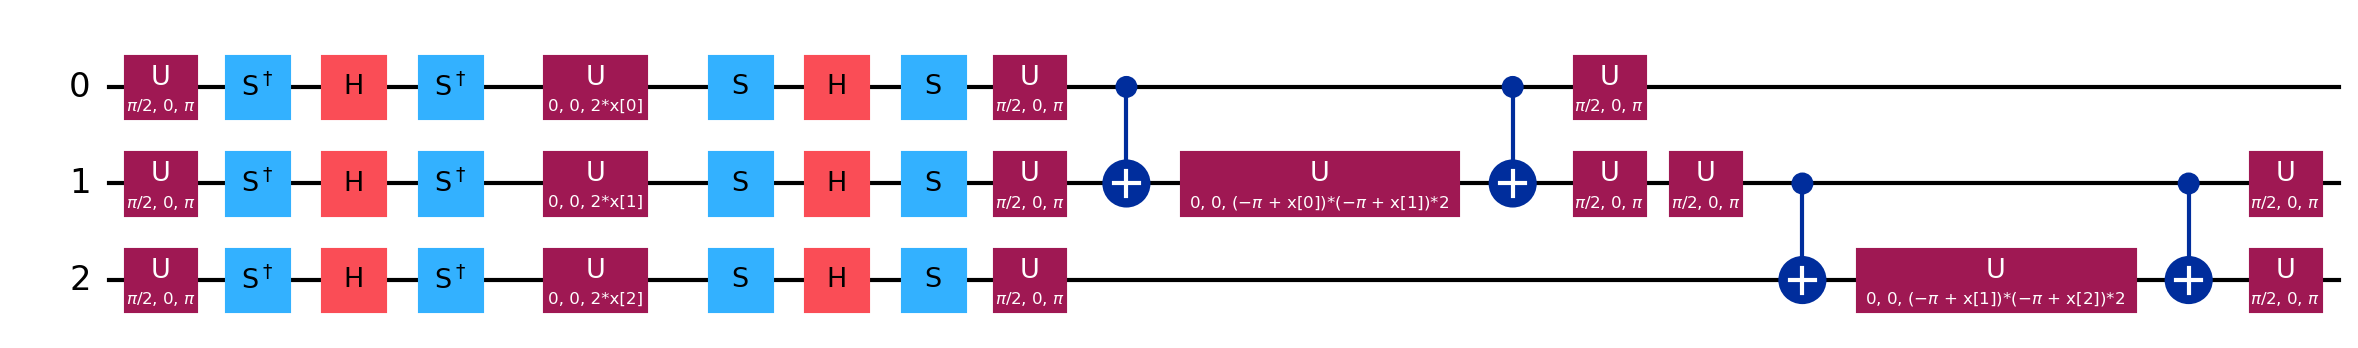

In [15]:
from qiskit.circuit.library import pauli_feature_map

feature_dim = 3
pfmap = pauli_feature_map(
feature_dimension=feature_dim, entanglement="linear", reps=1, paulis=["Y", "XX"]
)

pfmap.decompose().draw("mpl", scale=1.5)

Each repetition applies **Hadamard layers** followed by **Pauli interactions** defined by the chosen Pauli strings.  
The combination `["Y", "XX"]` includes both **single-qubit $Y$ rotations** and **two-qubit $XX$ couplings**.

---

### Parameter Scaling (α)

The PFM introduces a tunable scaling factor $\alpha$ that controls the **rotation strength** of all Pauli interactions:

$$
U(\mathbf{x}) =
\exp\left(
i \alpha
\sum_{S \subseteq [n]}
\phi_S(\mathbf{x})
\prod_{i \in S} \sigma_i
\right).
$$

- **Default value:** $\alpha = 2$  
- **Optimization:** Adjusting $\alpha$ (e.g., within the range $[0, 4]$) can improve how well the quantum kernel aligns with data features.

---

**Example 2. Gallery of Two-Qubit Pauli Feature Maps**

The following visualization shows multiple PFMs built with various Pauli combinations,  
demonstrating how different operator choices lead to distinct circuit architectures.


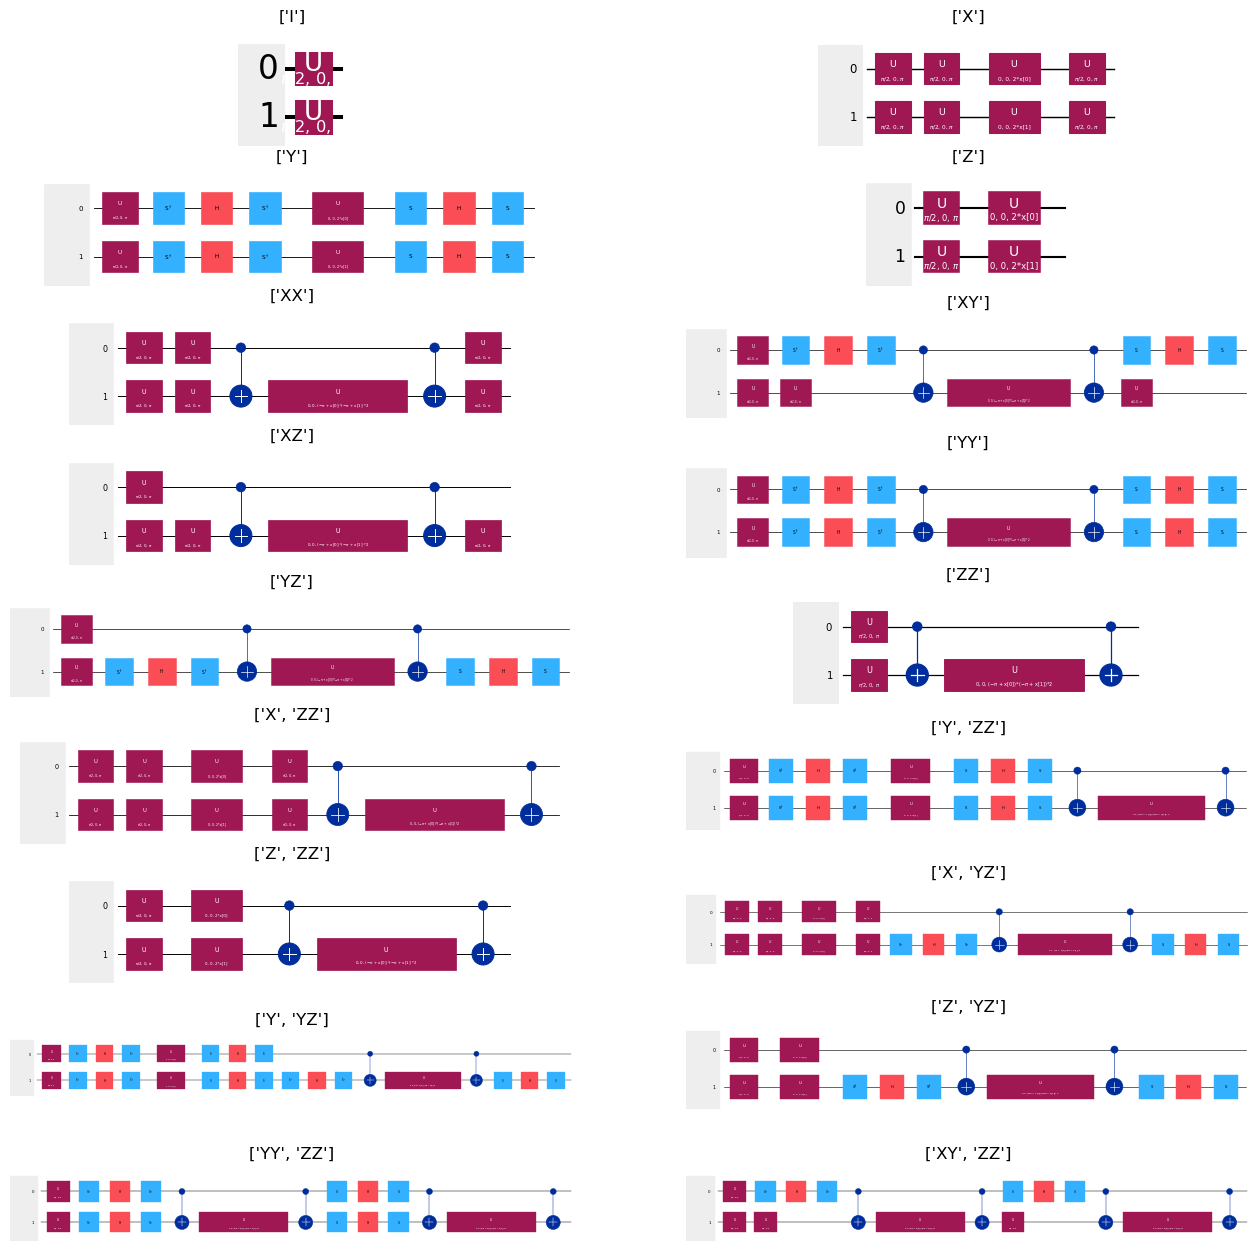

In [18]:
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt
 
feature_dim = 2
fig, axs = plt.subplots(9, 2)
i_plot = 0
for paulis in [
    ["I"],
    ["X"],
    ["Y"],
    ["Z"],
    ["XX"],
    ["XY"],
    ["XZ"],
    ["YY"],
    ["YZ"],
    ["ZZ"],
    ["X", "ZZ"],
    ["Y", "ZZ"],
    ["Z", "ZZ"],
    ["X", "YZ"],
    ["Y", "YZ"],
    ["Z", "YZ"],
    ["YY", "ZZ"],
    ["XY", "ZZ"],
]:
    pfmap = pauli_feature_map(feature_dimension=feature_dim, paulis=paulis, reps=1)
    circuit_drawer(
        pfmap.decompose(),
        output="mpl",
        style={"backgroundcolor": "#EEEEEE"},
        ax=axs[int((i_plot - i_plot % 2) / 2), i_plot % 2],
    )
    axs[int((i_plot - i_plot % 2) / 2), i_plot % 2].title.set_text(paulis)
    i_plot += 1
 
fig.set_figheight(16)
fig.set_figwidth(16)

**Your turn.** Create a `pauli_feature_map` circuit with  `feature_dimension=4`, `paulis=["Z", "YZ"]`, and `reps=2`.  
Use `"circular"` entanglement and draw the decomposed circuit.

## 7) Comparing Two-Qubit Gate Counts

Two-qubit (entangling) gates — such as `CX` — are the main source of **noise and decoherence**  
in today’s quantum hardware.  

To evaluate the practical efficiency of different feature maps,  
we can **decompose** each circuit and count the total number of `cx` gates required.  
This helps compare how encoding choices affect **hardware cost** as we increase  
the number of input features.

Below, we replicate the lesson’s quick benchmark:  
counting `cx` gates for each feature map while scaling feature dimensions.


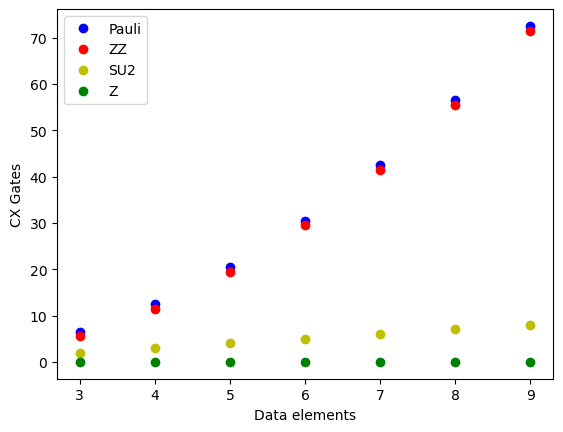

In [19]:
# Initialize parameters and empty lists for depths (from the lesson pattern)
x = [0.1, 0.2]
n_data, zz2gates, su22gates, z2gates, p2gates = [], [], [], [], []

for n in range(3, 10):
    x.append(n / 10)
    zzcircuit = zz_feature_map(n, reps=1, insert_barriers=True)
    zcircuit  = z_feature_map(n, reps=1, insert_barriers=True)
    su2circuit = efficient_su2(n, reps=1, insert_barriers=True)
    pcircuit = pauli_feature_map(n, reps=1, paulis=["XX"], insert_barriers=True)

    zzcx  = zzcircuit.decompose().count_ops().get("cx")
    zcx   = zcircuit.decompose().count_ops().get("cx")
    su2cx = su2circuit.decompose().count_ops().get("cx")
    pcx   = pcircuit.decompose().count_ops().get("cx")

    n_data.append(n)
    zz2gates.append((zzcx or 0) - 0.5)  # small horizontal jitter
    z2gates.append(0 if zcx is None else zcx)
    su22gates.append(0 if su2cx is None else su2cx)
    p2gates.append((pcx or 0) + 0.5)

plt.plot(n_data, p2gates, "bo")
plt.plot(n_data, zz2gates, "ro")
plt.plot(n_data, su22gates, "yo")
plt.plot(n_data, z2gates, "go")
plt.ylabel("CX Gates")
plt.xlabel("Data elements")
plt.legend(["Pauli", "ZZ", "SU2", "Z"])
plt.show()


## 8) Hardware-Efficient Notes

- Real devices have **native gate sets** and **specific coupling maps**.  
  Transpilation automatically inserts `SWAP` gates and decomposes operations to match hardware constraints.  
- To keep circuits reliable on **NISQ** (noisy intermediate-scale quantum) devices:
  - prefer **shallower** encodings,
  - reduce **two-qubit layers** or choose **linear entanglement**,  
  - select a **sub-topology** with longer $T_1/T_2$ times and lower 2-qubit error rates.

In short, circuit **depth and entanglement density** directly influence performance on real hardware.  
Efficient, noise-aware encoding is often more useful than highly expressive but deep circuits.

---



## Wrap-up — Quick Self-Check

<details>
<summary>1. Why is <b>data encoding</b> considered a form of <b>feature mapping</b> in quantum machine learning?</summary>

A. Because encoding skips the need for feature extraction  
B. Because encoding transforms classical inputs into quantum states in a higher-dimensional Hilbert space 
C. Because it replaces the optimization process  
D. Because it prevents entanglement between qubits
</details>

---

<details>
<summary>2. What determines whether a quantum feature map is <b>classically simulatable</b> or <b>quantum-advantageous</b>?</summary>

A. The number of parameters in the feature map  
B. The presence and complexity of entanglement between qubits  
C. The use of rotation gates instead of amplitude encoding  
D. The number of measurement shots used
</details>

---

<details>
<summary>3. How does increasing <b>entanglement</b> in a feature map change the way data is represented?</summary>

A. It removes redundant features from the input  
B. It encodes correlations between features, enabling richer representations 
C. It simplifies the quantum circuit structure 
D. It reduces the effective number of qubits
</details>

---

<details>
<summary>4. What role does the <b>Hilbert space dimensionality</b> play in quantum feature encoding?</summary>

A. It limits the number of qubits usable for encoding  
B. It determines the number of layers in the circuit  
C. It defines an exponentially large space ($2^n$) for data representation 
D. It ensures linear relationships between encoded features
</details>

---

<details>
<summary>5. Why might increasing the number of <b>repetitions</b> or circuit depth not always improve performance?</summary>

A. Deeper circuits always improve accuracy  
B. Deeper circuits can introduce noise and reduce trainability 
C. More repetitions reduce the number of trainable parameters  
D. Circuit depth affects only hardware connectivity
</details>

---

<details>
<summary>6. How do <b>rotation-based encodings</b> (like EfficientSU2) differ fundamentally from <b>amplitude encoding</b>?</summary>

A. Rotation-based encodings use gate angles, while amplitude encoding embeds data in quantum amplitudes 
B. Both methods store data in the same way  
C. Amplitude encoding requires no data normalization  
D. Rotation-based encodings are impossible to run on hardware
</details>

---

<details>
<summary>7. In what sense can the <b>Pauli Feature Map</b> be viewed as a general framework for quantum embeddings?</summary>

A. It eliminates all local rotations from the encoding  
B. It unifies ZFM and ZZFM by allowing arbitrary Pauli operators for feature interactions 
C. It restricts interactions to only single-qubit gates  
D. It replaces feature encoding with measurement sampling
</details>
